# **PACKAGES**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_DIR = os.getcwd()
if not ROOT_DIR.endswith('sendy_scripts'):
    ROOT_DIR = os.path.dirname(ROOT_DIR)
    
os.chdir(ROOT_DIR)

from src.processors import Preprocessor
from src.models import XGB_Model, LGB_Model
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_validate

/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


.

# **DATA LOADING**

In [3]:
train = pd.read_csv("../data/Train.csv")
test = pd.read_csv("../data/Test.csv")
riders = pd.read_csv("../data/Riders.csv")
submission = pd.read_csv("../data/SampleSubmission.csv")

# **DATA PREPROCESSING**

In [4]:
train, target = Preprocessor().separate_train_target(train)

In [5]:
train = Preprocessor().preprocess_data(train, True)
test = Preprocessor().preprocess_data(test, False)

In [6]:
all_data = Preprocessor().join_train_test(train, test)

In [7]:
all_data = Preprocessor().ohe_matrix(all_data)

In [14]:
all_data = all_data.drop("Pickup - Time", axis=1)

In [13]:
all_data.head()

,x0_User_Id_0,x0_User_Id_1,x0_User_Id_10,x0_User_Id_100,x0_User_Id_1000,x0_User_Id_1001,x0_User_Id_1002,x0_User_Id_1003,x0_User_Id_1004,x0_User_Id_1005,...,x10_1,x10_2,x10_3,x10_4,x10_5,x10_6,x10_7,Platform Type,Pickup - Time,is_train
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,3,10:27:30 AM,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,3,11:44:09 AM,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,3,12:53:03 PM,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,3,9:43:06 AM,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,10:05:23 AM,1


In [27]:
all_data = all_data.astype("int64")

In [28]:
train, test = Preprocessor().separate_train_test(all_data)

.

# **MODELIZATION**

## **XGBOOST**

In [41]:
dtrain = XGB_Model().prepare_data(train[list(test.drop("", axis=1).columns)], target)
dtest = XGB_Model().prepare_data(test.drop("Pickup - Time", axis=1), None)

/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [7]:
xgb_params = {
    'max_depth': 4, 
    'eta': 0.1, 
    'objective': 'reg:squarederror',
    'nthread'  : 4,
    'eval_metric' : "rmse",
}

In [8]:
cv_rmse_xgb = XGB_Model().train_xgb_cv(dtrain, params=xgb_params, nfold=10, num_boost_round=1000)

In [57]:
print("Argmin is:", np.argmin(cv_rmse_xgb['test-rmse-mean']), "and the minimum is :", np.min(cv_rmse_xgb['test-rmse-mean']))

Argmin is: 379 and the minimum is : 764.4604249000001


/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


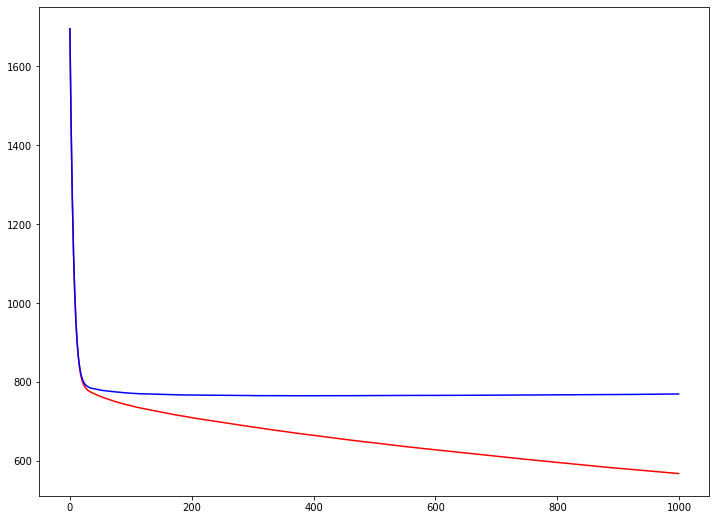

In [37]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_xgb['train-rmse-mean'], color="red")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] + cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] - cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
plt.plot(cv_rmse_xgb['test-rmse-mean'], color="blue")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] + cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] - cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")

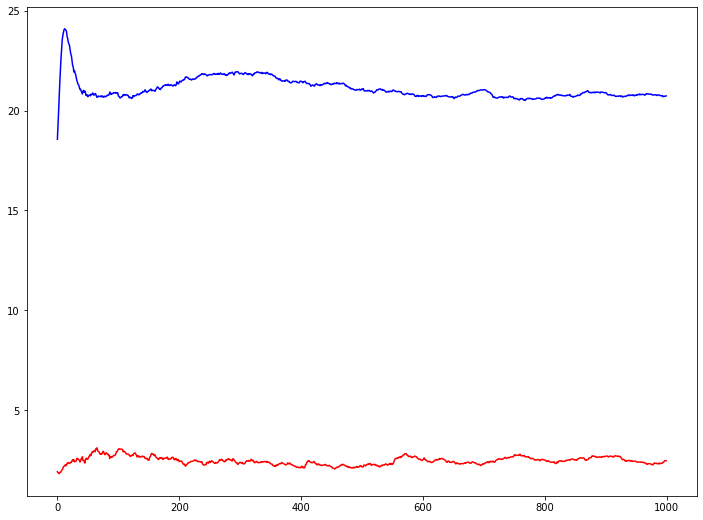

In [38]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_xgb['train-rmse-std'], color="red")
plt.plot(cv_rmse_xgb['test-rmse-std'], color="blue")

In [58]:
xgb_model = XGB_Model().train_xgb(dtrain,  xgb_params, 379)

In [59]:
xgb_pred = xgb_model.predict(dtest)
xgb_pred_train = xgb_model.predict(dtrain)

In [60]:
xgb_submission = submission
xgb_submission["Time from Pickup to Arrival"].loc[3:] = np.round(xgb_pred[3:])


In [61]:
xgb_submission.to_csv("../submissions/XgBoost_1.csv", index=False)

.

## LightGBM

In [29]:
dtrain = LGB_Model().prepare_data(train[list(test.columns)], target)
dtest = LGB_Model().prepare_data(test, None)

In [30]:
lgb_params = {
    'boosting': "gbdt", 
    'learning_rate': 0.1, 
    'objective': 'regression',
    'num_threads'  : 4,
    'metric' : "rmse",
}

In [34]:
cv_rmse_lgb = LGB_Model().train_lgb_cv(dtrain, params=lgb_params, nfold=6, num_boost_round=1000)

In [17]:
for key in cv_rmse_lgb.keys():
    print(key)

rmse-mean
rmse-stdv


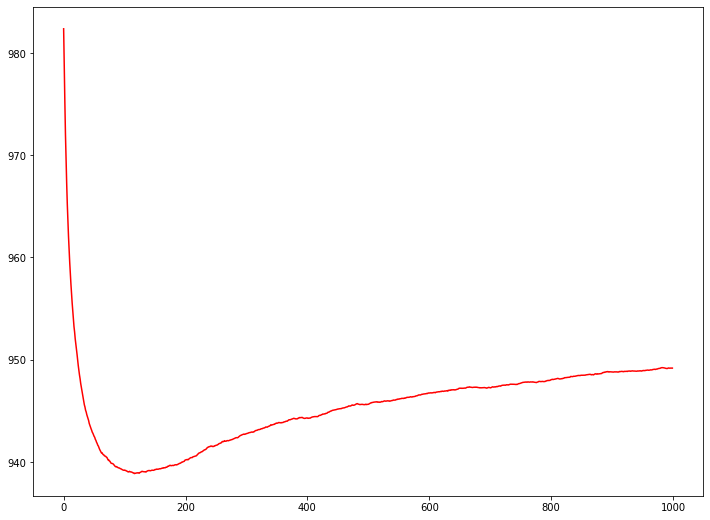

In [35]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_lgb['rmse-mean'], color="red")
#plt.plot(cv_rmse_xgb['test-rmse-mean'], color="blue")

In [36]:
print("Argmin is:", np.argmin(cv_rmse_lgb['rmse-mean']), "and the minimum is :", np.min(cv_rmse_lgb['rmse-mean']))

Argmin is: 116 and the minimum is : 938.8606444728326


In [37]:
lgb_num_boost = np.argmin(cv_rmse_lgb['rmse-mean'])

In [38]:
lgb_model = LGB_Model().train_lgb(dtrain,  lgb_params, lgb_num_boost)

In [39]:
#lgb_pred = lgb_model.predict(test.drop("Order No", axis=1))
#lgb_pred_train = lgb_model.predict(train.drop("Order No", axis=1))

lgb_pred = lgb_model.predict(test)
lgb_pred_train = lgb_model.predict(train)

In [40]:
lgb_submission = submission
lgb_submission["Time from Pickup to Arrival"].loc[3:] = np.round(lgb_pred[3:])


/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [41]:
lgb_submission.to_csv("../submissions/Lgbm_Ohe.csv", index=False)

# **STACKING LGB AND XGB**

In [21]:
lgb_pred

array([1685.49646494, 1223.18659448, 1222.66285245, ..., 1618.77193428,
       2626.73693584, 1882.21894482])

In [22]:
xgb_pred

array([1313.0885, 1296.8817, 1214.0266, ..., 1852.8407, 2400.1885,
       1871.9578], dtype=float32)

In [43]:
X_stack = np.vstack((lgb_pred_train, xgb_pred_train)).T

In [53]:
X_stack[0,:]

array([1219.49834678,  608.81115723])

In [45]:
lasso_stck = Lasso(alpha=0.1)

cv_results = cross_validate(lasso_stck, X_stack, target, cv=6)


In [47]:
cv_results["test_score"]

array([0.66518768, 0.65087828, 0.66530051, 0.68168959, 0.68510739,
       0.66369297])

In [48]:
lasso_stck = lasso_stck.fit(X_stack, target)

In [49]:
lasso_stck_pred = lasso_stck.predict(np.vstack((lgb_pred, xgb_pred)).T)

In [50]:
lasso_stck_submission = submission
lasso_stck_submission["Time from Pickup to Arrival"].loc[3:] = np.round(lasso_stck_pred[3:])
lasso_stck_submission.to_csv("../submissions/Lasso_Stack_1.csv", index=False)

/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
